In [1]:
import nibabel as nib
import numpy as np
import glob
from skimage.transform import resize

In [2]:
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import seaborn as sns

In [29]:
dir1 = "/home/anshul/Datasets_Analyze/AMOS_Dataset/amos22/imagesTr"
dir2 = "/home/anshul/Datasets_Analyze/Amos_Labels"
dir3 = "/home/anshul/Datasets_Analyze/AMOS_Dataset/amos22/imagesVa"

# train_list = glob.glob(dir1 + "/*.nii.gz", recursive = True)
# val_list = glob.glob(dir + "/*.nii.gz", recursive = True)
# label_list = glob.glob(dir2 + "/*.nii.gz", recursive = True)

train = []
label = []
for i in os.listdir(dir1):
    if(i.endswith(".nii.gz")):
        path_train = os.path.join(dir1, i)
        path_label = os.path.join(dir2, i[:-7], "6.nii.gz")
        train_img = nib.load(path_train)
        label_img = nib.load(path_label)
        train_data = train_img.get_fdata()
        label_data = label_img.get_fdata()
        output_shape = (128,128,128)
        resized_train = resize(train_data, output_shape, order = 1, preserve_range = 2)
        resized_label = resize(label_data, output_shape, order = 1, preserve_range = 2)
        train.append(resized_train)
        label.append(resized_label)

print(len(train))
print(len(label)) 

for i in os.listdir(dir3):
    if(i.endswith(".nii.gz")):
        path_train = os.path.join(dir3, i)
        path_label = os.path.join(dir2, i[:-7], "6.nii.gz")
        train_img = nib.load(path_train)
        label_img = nib.load(path_label)
        train_data = train_img.get_fdata()
        label_data = label_img.get_fdata()
        output_shape = (128,128,128)
        resized_train = resize(train_data, output_shape, order = 1, preserve_range = 2)
        resized_label = resize(label_data, output_shape, order = 1, preserve_range = 2)
        train.append(resized_train)
        label.append(resized_label) 

print(len(train))
print(len(label))

np.save('/home/anshul/Datasets_Analyze/Binary_Segmentation/Train.npy', train)
np.save('/home/anshul/Datasets_Analyze/Binary_Segmentation/6.npy', label)

240
240
360
360


### Binary classification Liver

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda Available')
else:
    print('CPU only')

CPU only


In [5]:
class Args:
    def __init__(self):
        self.batch_size = 4
        self.log_interval = 10
        self.learning_rate = 1e-2
        self.epochs = 25
        self.train_val_prop = 0.9
        self.epochs = 2
args = Args()

In [9]:
X = np.load('C:\\Users\\Dell\\Desktop\\Internships\\IISc\\Train.npy')
X = np.reshape(X, (-1, 1, 128, 128, 128))
print(X.shape)
X = X / np.percentile(X, 99.9)
X[ X > 1] = 1
X = X - np.mean(X)

ValueError: cannot reshape array of size 7929840 into shape (360,128,128,128)

In [10]:
y = np.load('C:\\Users\\Dell\\Desktop\\Internships\\IISc\\6.npy')
print(y.shape)
# Convert to one hot
y_store = np.zeros((len(y), 2, 128, 128, 128))
y_store[:,0,:,:,:][y == 0] = 1
y_store[:,1,:,:,:][y == 1] = 1
y = y_store
# Lets have a look at this and make sure its sensible

subj = 10
for subj in range(10):
    plt.subplot(1,3,1)
    plt.imshow(X[subj, 0, :, :, 100], cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(y[subj, 0, :, :, 100])
    plt.subplot(1,3,3)
    plt.imshow(y[subj, 1, :, :, 100])
    plt.show()

ValueError: cannot reshape array of size 14286832 into shape (360,128,128,128)

In [35]:
from torch.utils.data import Dataset
class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        self.transform = transform # This is where you can add augmentations

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [40]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)  # Same seed everytime
proportion = int(args.train_val_prop * len(X)) # Train val split 
X_train = X[:proportion]
X_val = X[proportion:]
y_train = y[:proportion]
y_val = y[proportion:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)

(324, 1, 128, 128, 128) (324, 2, 128, 128, 128)
(36, 1, 128, 128, 128) (36, 2, 128, 128, 128)


In [41]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0, drop_last=True)

In [42]:
from collections import OrderedDict
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, init_features=2):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose3d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose3d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose3d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose3d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.seg = nn.Conv3d( in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        seg = self.seg(dec1)
        return torch.sigmoid(seg)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=True,
                        ),
                    ),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "norm1", nn.BatchNorm3d(num_features=features)),

                    (
                        name + "conv2",
                        nn.Conv3d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=True,
                        ),
                    ),
                    (name + "relu2", nn.ReLU(inplace=True)),
                    (name + "norm2", nn.BatchNorm3d(num_features=features)),
                ]
            )
        )

In [45]:
model = UNet(in_channels=1, out_channels=2, init_features=2)
if cuda:
    model.cuda()

In [46]:
class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
        self.eps=1e-7

    def forward(self, x, target):
        num_classes = target.shape[1]   # Channels first
        target = target.type(x.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        intersection = torch.sum(x * target, dims)
        cardinality = torch.sum(x + target, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return (1 - dice_loss)

In [47]:
import torch.optim as optim
criterion = dice_loss()
if cuda:
    criterion.cuda()
optimizer = optim.Adam(list(model.parameters()), lr=args.learning_rate)


In [48]:
from torch.autograd import Variable

args.epochs = 20
loss_store = []
for epoch in range(1, args.epochs+1):
    print('Epoch ', epoch, '/', args.epochs, flush=True)
    
    # First train 
    total_loss = 0
    val_total_loss = 0
    model.train()      #Put the model in training mode
    batches = 0
    for batch_idx, (data, label) in enumerate(train_dataloader):
        if cuda:
            data = data.cuda()
            label = label.cuda()
        data = Variable(data)
        label = Variable(label)    # This calls autograd on our data
        
        batches += 1
        # Forward
        optimizer.zero_grad()
        seg_pred = model.forward(data)
        # Calc loss
        train_loss = criterion(seg_pred, label)
        # Backprop the loss
        train_loss.backward()
        optimizer.step()
        total_loss += train_loss

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data), len(train_dataloader.dataset),
                       100. * (batch_idx+1) / len(train_dataloader), train_loss.item()), flush=True)

    av_loss = (total_loss / batches).detach().cpu().numpy()   # If you dont detach it keeps the whole model
    print('Training set: Average loss: ',  av_loss, flush=True) 
    
    # Now val
    model.eval()
    batches = 0 
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_dataloader):
            if cuda:
                data = data.cuda()
                label = label.cuda()
            data = Variable(data)
            label = Variable(label)
            batches += 1
            pred_seg = model.forward(data)
            loss = criterion(pred_seg, label)
            val_total_loss += loss
    val_av_loss = (val_total_loss / batches).detach().cpu().numpy()
    print('Validation set: Average loss: ',  val_av_loss, flush=True)

    loss_store.append([av_loss, val_av_loss])   # Save the losses so we can plot them
    torch.cuda.empty_cache()  # Clear memory cache
        

Epoch  1 / 20
Train Epoch: 1 [4/324 (1%)]	Loss: 0.686672
Train Epoch: 1 [44/324 (14%)]	Loss: 0.648825
Train Epoch: 1 [84/324 (26%)]	Loss: 0.626540
Train Epoch: 1 [124/324 (38%)]	Loss: 0.590745
Train Epoch: 1 [164/324 (51%)]	Loss: 0.569281
Train Epoch: 1 [204/324 (63%)]	Loss: 0.551076
Train Epoch: 1 [244/324 (75%)]	Loss: 0.535719
Train Epoch: 1 [284/324 (88%)]	Loss: 0.526123
Train Epoch: 1 [324/324 (100%)]	Loss: 0.522111
Training set: Average loss:  0.58045506
Validation set: Average loss:  0.5208289
Epoch  2 / 20
Train Epoch: 2 [4/324 (1%)]	Loss: 0.522556
Train Epoch: 2 [44/324 (14%)]	Loss: 0.519989
Train Epoch: 2 [84/324 (26%)]	Loss: 0.513343
Train Epoch: 2 [124/324 (38%)]	Loss: 0.516383
Train Epoch: 2 [164/324 (51%)]	Loss: 0.515653
Train Epoch: 2 [204/324 (63%)]	Loss: 0.513446
Train Epoch: 2 [244/324 (75%)]	Loss: 0.507043
Train Epoch: 2 [284/324 (88%)]	Loss: 0.511616
Train Epoch: 2 [324/324 (100%)]	Loss: 0.506540
Training set: Average loss:  0.5138013
Validation set: Average loss:  0

(2, 20)


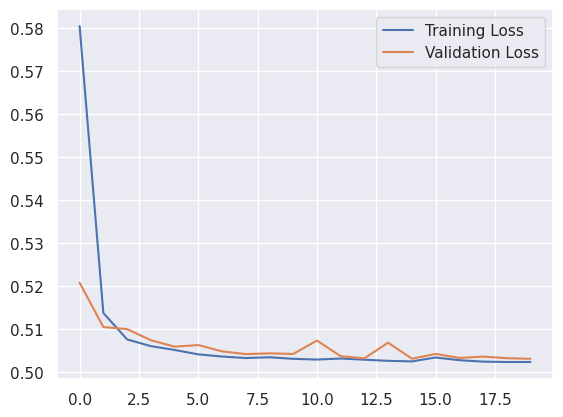

In [49]:
sns.set()
loss_store = np.array(loss_store).T
print(loss_store.shape)
plt.plot(loss_store[0,:])
plt.plot(loss_store[1,:])
plt.legend(['Training Loss', 'Validation Loss'])